# Check meta-model training as binary predictor

In [1]:
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

from pathlib import Path
import sys
sys.path.insert(0, Path(".").absolute().parent.as_posix())

from PIL import Image

import pandas as pd

import numpy as np
from common.dataset import FilesFromCsvDataset, TransformedDataset
from common.meta import get_metafeatures, get_imsize_and_targets

In [2]:
import matplotlib.pylab as plt
%matplotlib inline
import seaborn as sns

sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(12, 10)})

In [31]:
OUTPUT_PATH = Path(".").absolute().parent / "output" / "val_probas"

meta_features_list = [
    OUTPUT_PATH / "val_probas_inceptionv4_350_resized_crop" / "20180428_1633" / "probas.csv",
    OUTPUT_PATH / "val_probas_inceptionv4_350_cls_wts_adam_resized_crop" / "20180520_2026" / "probas.csv",
    OUTPUT_PATH / "val_probas_inceptionv4_350_fc_random_resized_crop" / "20180520_2032" / "probas.csv",
    
    OUTPUT_PATH / "val_probas_resnet152_350_adam_random_crop" / "20180522_1903" / "probas.csv",
    OUTPUT_PATH / "val_probas_resnet152_350_adam_random_crop" / "20180522_1905" / "probas.csv",
    OUTPUT_PATH / "val_probas_resnet152_350_amsgrad_adam_random_crop" / "20180523_2243" / "probas.csv",    
    
    OUTPUT_PATH / "val_probas_inceptionresnetv2_350_resized_crop" / "20180428_1622" / "probas.csv",
    OUTPUT_PATH / "val_probas_inceptionresnetv2_350_weighted_sampler2_resized_crop" / "20180501_1710" / "probas.csv",
    
    OUTPUT_PATH / "val_probas_nasnetalarge_350_resized_crop" / "20180428_1654" / "probas.csv",
    OUTPUT_PATH / "val_probas_nasnetalarge_350_random_resized_crop" / "20180514_2232" / "probas.csv",
    OUTPUT_PATH / "val_probas_nasnetalarge_350_random_resized_crop" / "20180514_2202" / "probas.csv",
]

## Prepare data

In [32]:
def create_topk_with_probas_df(df, k):
    df_values = df.values
    topk_values = np.argsort(df_values, axis=1)[:, -k:]
    topk_probas = np.zeros_like(topk_values, dtype=np.float)
    for i, indices in enumerate(topk_values):
        topk_probas[i, :] = df_values[i, indices]
    cols1 = ["top_{}".format(k - i) for i in range(k)]
    cols2 = ["top_{}_proba".format(k - i) for i in range(k)]
    data = np.concatenate([topk_values, topk_probas], axis=1)
    topk_df = pd.DataFrame(data, index=df.index, columns=cols1 + cols2)
    topk_df[cols1] = topk_df[cols1].astype(np.int)
    return topk_df


def get_topk_with_probas_metafeatures(prediction_files, k=5):
    dfs = [pd.read_csv(f, index_col='id') for f in prediction_files]
    dfs = [create_topk_with_probas_df(df, k=k) for df in dfs]
    for i, df in enumerate(dfs):
        df.columns = ["f{}_{}".format(i, c) for c in df.columns]
    meta_features = pd.concat([df for df in dfs], axis=1)
    return meta_features

In [33]:
n_models = len(meta_features_list)
k = 4

In [34]:
dataset = FilesFromCsvDataset("../output/unique_filtered_val_dataset.csv")
dataset = TransformedDataset(dataset,
                             transforms=lambda x: (x, Image.open(x).size),
                             target_transforms=lambda l: l - 1)
df_imsize_targets = get_imsize_and_targets(dataset)
y_true = df_imsize_targets['target']

In [35]:
meta_features_init = get_topk_with_probas_metafeatures(meta_features_list, k=k)
meta_features_init = meta_features_init.loc[y_true.index, :]

meta_features_init.loc[:, 'y_pred'] = -1
meta_features_init.loc[:, 'y_true'] = y_true

dfs = []

for i in range(n_models):
    for j in range(1, k + 1):
        df = meta_features_init.copy()
        df['y_pred'] = df['f{}_top_{}'.format(i, j)]
        dfs.append(df)
        
meta_features = pd.concat(dfs, axis=0)
meta_features = meta_features[~meta_features.duplicated()]

meta_features.shape

(52948, 90)

In [36]:
meta_features.loc[1205, :]

,f0_top_4,f0_top_3,f0_top_2,f0_top_1,f0_top_4_proba,f0_top_3_proba,f0_top_2_proba,f0_top_1_proba,f1_top_4,f1_top_3,...,f10_top_4,f10_top_3,f10_top_2,f10_top_1,f10_top_4_proba,f10_top_3_proba,f10_top_2_proba,f10_top_1_proba,y_pred,y_true
1205,28,22,14,62,0.007003,0.031993,0.171253,0.7806,28,22,...,28,22,14,62,0.006772,0.163155,0.269543,0.55669,62,62
1205,28,22,14,62,0.007003,0.031993,0.171253,0.7806,28,22,...,28,22,14,62,0.006772,0.163155,0.269543,0.55669,14,62
1205,28,22,14,62,0.007003,0.031993,0.171253,0.7806,28,22,...,28,22,14,62,0.006772,0.163155,0.269543,0.55669,22,62
1205,28,22,14,62,0.007003,0.031993,0.171253,0.7806,28,22,...,28,22,14,62,0.006772,0.163155,0.269543,0.55669,28,62
1205,28,22,14,62,0.007003,0.031993,0.171253,0.7806,28,22,...,28,22,14,62,0.006772,0.163155,0.269543,0.55669,3,62


In [37]:
meta_features.loc[:, 'target'] = (meta_features['y_pred'] == meta_features['y_true']).astype(np.int)

In [38]:
meta_features.head()

,f0_top_4,f0_top_3,f0_top_2,f0_top_1,f0_top_4_proba,f0_top_3_proba,f0_top_2_proba,f0_top_1_proba,f1_top_4,f1_top_3,...,f10_top_3,f10_top_2,f10_top_1,f10_top_4_proba,f10_top_3_proba,f10_top_2_proba,f10_top_1_proba,y_pred,y_true,target
6302,36,96,52,47,8.939854e-09,2.021888e-08,3.179983e-07,1.000000,96,36,...,36,52,47,0.000017,0.000018,0.000073,0.999869,47,47,1
3349,71,8,106,78,1.221437e-03,4.590297e-03,1.697846e-02,0.976116,71,8,...,71,106,78,0.000484,0.002700,0.005359,0.990709,78,78,1
484,2,21,44,118,4.046735e-09,3.343205e-07,5.579347e-07,0.999999,44,42,...,21,0,118,0.000016,0.000032,0.000033,0.999911,118,118,1
2677,81,99,111,26,3.559150e-09,6.325067e-08,6.518025e-06,0.999993,81,99,...,99,111,26,0.000016,0.000155,0.000182,0.999620,26,26,1
1517,119,20,21,16,1.030732e-02,1.466374e-02,1.823608e-02,0.948546,20,21,...,21,91,16,0.007766,0.026205,0.069932,0.889029,16,21,0


### Majority vote top-1 baseline

In [39]:
top1_cols = ["f{}_top_1".format(i) for i in range(n_models)]

In [40]:
y_pred_baseline = meta_features_init[top1_cols].apply(lambda row: np.argmax(np.bincount(row)), axis=1)

In [41]:
y_true.shape, y_pred_baseline.shape

((6263,), (6263,))

In [42]:
from sklearn.metrics import accuracy_score

1.0 - accuracy_score(y_true.values, y_pred_baseline.values)

0.11991058598115922

In [19]:
# from sklearn.metrics import accuracy_score

# 1.0 - accuracy_score(y_true.values, y_pred_baseline.values)

In [43]:
(y_true.values != y_pred_baseline.values).sum(), y_true.shape

(751, (6263,))

### Train meta models

In [44]:
# meta_features = pd.concat([meta_features, pd.get_dummies(meta_features['y_pred'], prefix='y_pred')], axis=1)

In [45]:
train_columns = meta_features.columns.tolist()
# train_columns.remove('y_pred')
train_columns.remove('y_true')
train_columns.remove('target')

In [46]:
len(train_columns)

89

Add feature interactions

In [64]:
interaction_train_columns = []
for i, c1 in enumerate(train_columns):
    for j, c2 in enumerate(train_columns):
        if i < j:
            interaction_train_columns.append("{} {}".format(c1, c2))

In [66]:
len(interaction_train_columns)

3240

In [107]:
for fname in interaction_train_columns:
    if " " in fname:
        f1, f2 = fname.split(" ")
        if "proba" in f1 and "proba" in f2:
            meta_features.loc[:, fname] = 0.0
            meta_features.loc[:, fname] = meta_features[f1] * meta_features[f2]
        elif "proba" not in f1 and "proba" not in f2:
            meta_features.loc[:, fname] = ""
            meta_features.loc[:, fname] = meta_features[f1].astype(str) + " " + meta_features[f2].astype(str)

In [108]:
meta_features.shape

(51533, 1780)

Trainval / Test split

We need to split meta_features_init in order to avoid dataleak 

In [47]:
from sklearn.model_selection import StratifiedShuffleSplit

seed = 12
split = StratifiedShuffleSplit(random_state=seed, test_size=0.4)

y_total = meta_features_init['y_true']

train_index, test_index = next(split.split(y_total, y_total))

In [48]:
train_idx = meta_features_init.index[train_index]
test_idx = meta_features_init.index[test_index]

In [74]:
important_train_columns = ['f0_top_2', 'f0_top_1', 'f1_top_1', 'f2_top_1', 'f3_top_1',
       'f4_top_1', 'f5_top_1', 'f6_top_1', 'f6_top_3_proba', 'f7_top_1',
       'f8_top_1', 'f8_top_3_proba', 'f8_top_2_proba', 'f9_top_1',
       'f10_top_1', 'y_pred']

In [75]:
train_columns_ = important_train_columns
# train_columns_ = train_columns

In [76]:
x_trainval = meta_features.loc[train_idx, train_columns_].values
y_trainval = meta_features.loc[train_idx, 'target'].values

x_test = meta_features.loc[test_idx, train_columns_].values
y_test = meta_features.loc[test_idx, 'target'].values

In [77]:
np.bincount(y_trainval), np.bincount(y_test)

(array([27971,  3744]), array([18740,  2493]))

GBM as meta-model

In [78]:
import lightgbm as lgb

In [79]:
lgb_trainval = lgb.Dataset(x_trainval, label=y_trainval, feature_name=train_columns_)

In [80]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'num_leaves': 35,
    'max_depth': 200,
    'learning_rate': 0.00075,
#     'feature_fraction': 0.75,
#     'bagging_fraction': 0.8,
#     'bagging_freq': 5,
}

In [81]:
num_boost_round = 250000

In [82]:
cv_results = lgb.cv(params, lgb_trainval, num_boost_round=num_boost_round, nfold=5,
                    metrics='auc',                    
                    early_stopping_rounds=500, verbose_eval=500)

[500]	cv_agg's auc: 0.837047 + 0.0429524
[1000]	cv_agg's auc: 0.875236 + 0.0240233
[1500]	cv_agg's auc: 0.890238 + 0.0195913
[2000]	cv_agg's auc: 0.903437 + 0.00886812
[2500]	cv_agg's auc: 0.913686 + 0.00497642
[3000]	cv_agg's auc: 0.921622 + 0.00556528
[3500]	cv_agg's auc: 0.926437 + 0.00521093
[4000]	cv_agg's auc: 0.930836 + 0.0049186
[4500]	cv_agg's auc: 0.934285 + 0.00516838
[5000]	cv_agg's auc: 0.936795 + 0.00530043
[5500]	cv_agg's auc: 0.939105 + 0.00502712
[6000]	cv_agg's auc: 0.940868 + 0.0050614
[6500]	cv_agg's auc: 0.942495 + 0.00544645
[7000]	cv_agg's auc: 0.943768 + 0.00600507
[7500]	cv_agg's auc: 0.944797 + 0.00631845
[8000]	cv_agg's auc: 0.945631 + 0.00667547
[8500]	cv_agg's auc: 0.946436 + 0.00664919
[9000]	cv_agg's auc: 0.947125 + 0.0065632
[9500]	cv_agg's auc: 0.947881 + 0.00665796
[10000]	cv_agg's auc: 0.94863 + 0.00660453
[10500]	cv_agg's auc: 0.949309 + 0.00648263
[11000]	cv_agg's auc: 0.949991 + 0.0064567
[11500]	cv_agg's auc: 0.950701 + 0.00642575
[12000]	cv_agg's

In [83]:
best_boost_round = np.argmax(cv_results['auc-mean'])
best_boost_round, np.max(cv_results['auc-mean'])

(32642, 0.9610062869735453)

In [84]:
gbm = lgb.train(params, lgb_trainval, num_boost_round=best_boost_round)

In [85]:
y_test_probas = gbm.predict(x_test)

In [86]:
y_test_pred = (y_test_probas > 0.5).astype(np.int)

In [87]:
meta_features.loc[:, 'bin_pred'] = 0
meta_features.loc[test_idx, 'bin_pred'] = y_test_pred

In [88]:
y_test_true = meta_features_init.loc[test_idx, 'y_true'].values

In [89]:
df_ = meta_features.loc[test_idx, ['bin_pred', 'y_pred']]
y_test_pred = np.zeros_like(y_test_true)
assert len(y_test_pred) == len(test_idx)
for i, idx in enumerate(test_idx):
    d = df_.loc[idx].values
    if d[:, 0].sum() >= 1:
        y_test_pred[i] = d[d[:, 0] > 0, 1][0]
    else:
        y_test_pred[i] = d[0, 1]

Compare with baseline:

In [90]:
1.0 - accuracy_score(y_test_true, y_test_pred), 1.0 - accuracy_score(y_true[test_idx].values, y_pred_baseline[test_idx].values)

(0.12649640861931366, 0.11612130885873906)

In [64]:
1.0 - accuracy_score(y_test_true, y_test_pred), 1.0 - accuracy_score(y_true[test_idx].values, y_pred_baseline[test_idx].values)

(0.13128491620111726, 0.11612130885873906)

In [140]:
1.0 - accuracy_score(y_test_true, y_test_pred), 1.0 - accuracy_score(y_true[test_idx].values, y_pred_baseline[test_idx].values)

(0.1213088587390263, 0.11851556264964092)

In [57]:
1.0 - accuracy_score(y_test_true, y_test_pred), 1.0 - accuracy_score(y_true[test_idx].values, y_pred_baseline[test_idx].values)

(0.12729449321628095, 0.11851556264964092)

In [72]:
feature_importance = gbm.feature_importance()

important_col_indices = np.where(feature_importance > 0.025 * feature_importance.max())[0]

In [73]:
np.array(gbm.feature_name())[important_col_indices]

array(['f0_top_2', 'f0_top_1', 'f1_top_1', 'f2_top_1', 'f3_top_1',
       'f4_top_1', 'f5_top_1', 'f6_top_1', 'f6_top_3_proba', 'f7_top_1',
       'f8_top_1', 'f8_top_3_proba', 'f8_top_2_proba', 'f9_top_1',
       'f10_top_1', 'y_pred'], dtype='<U15')

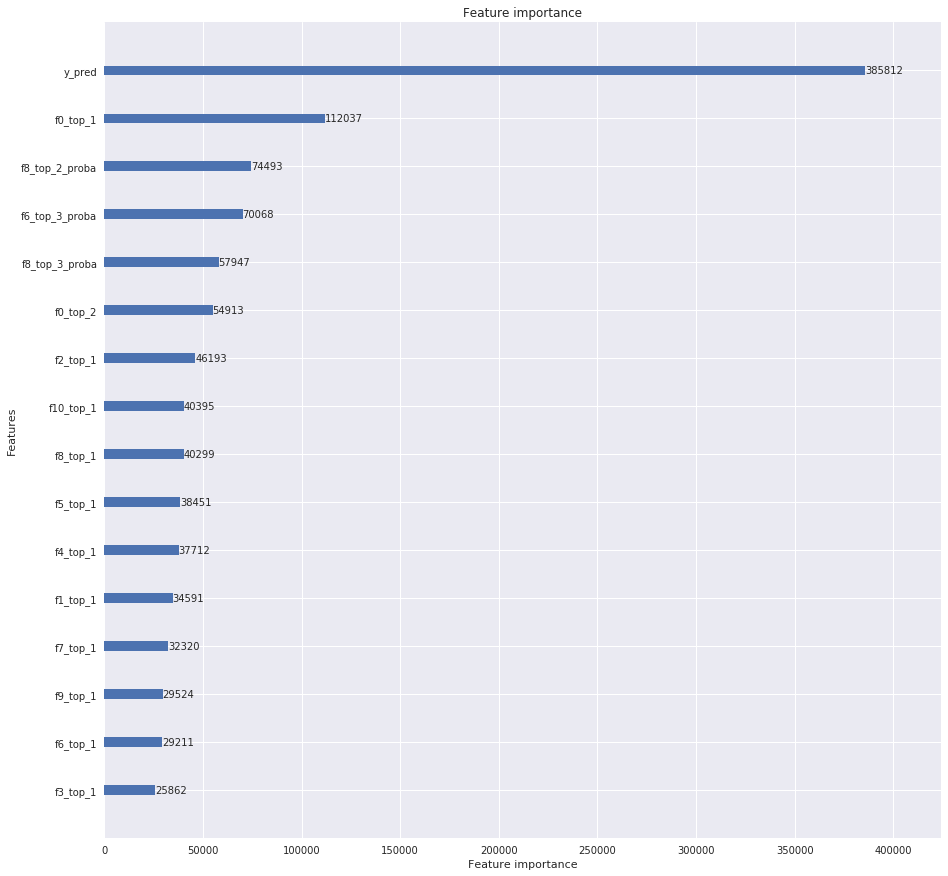

In [91]:
lgb.plot_importance(gbm, figsize=(15, 15))

## Apply on the test data

In [101]:
!ls {test_meta_features_path}/test_probas_nasnetalarge_350_resized_crop

20180429_1406


In [92]:
OUTPUT_PATH = Path(".").absolute().parent / "output" / "test_probas"

test_meta_features_list = [
    
    OUTPUT_PATH / "test_probas_inceptionv4_350_resized_crop" / "20180429_1303" / "probas.csv",    
    OUTPUT_PATH / "test_probas_inceptionv4_350_cls_wts_adam_resized_crop" / "20180520_2151" / "probas.csv",
    OUTPUT_PATH / "test_probas_inceptionv4_350_fc_random_resized_crop" / "20180520_2151" / "probas.csv",
    
    OUTPUT_PATH / "test_probas_resnet152_350_adam_random_crop" / "20180522_2014" / "probas.csv",
    OUTPUT_PATH / "test_probas_resnet152_350_adam_random_crop" / "20180522_2039" / "probas.csv",
    OUTPUT_PATH / "test_probas_resnet152_350_amsgrad_adam_random_crop" / "20180523_2307" / "probas.csv",
    
    OUTPUT_PATH / "test_probas_inceptionresnetv2_350_resized_crop" / "20180429_1242" / "probas.csv",
    OUTPUT_PATH / "test_probas_inceptionresnetv2_350_weighted_sampler2_resized_crop" / "20180501_1725" / "probas.csv",
    
    OUTPUT_PATH / "test_probas_nasnetalarge_350_resized_crop" / "20180429_1406" / "probas.csv",
    OUTPUT_PATH / "test_probas_nasnetalarge_350_random_resized_crop" / "20180514_1034" / "probas.csv",    
    OUTPUT_PATH / "test_probas_nasnetalarge_350_random_resized_crop" / "20180514_0821" / "probas.csv",
]


In [93]:
test_dfs = [pd.read_csv(f, index_col='id') for f in test_meta_features_list]

In [94]:
print([df.shape for df in test_dfs])

[(12639, 128), (12665, 128), (12665, 128), (12665, 128), (12665, 128), (12665, 128), (12639, 128), (12664, 128), (12639, 128), (12665, 128), (12665, 128)]


In [95]:
test_dfs[0].shape

(12639, 128)

In [96]:
test_meta_features_init = get_topk_with_probas_metafeatures(test_meta_features_list, k=k)
test_meta_features_init = test_meta_features_init.loc[test_dfs[0].index, :]
test_meta_features_init.loc[:, 'y_pred'] = -1

dfs = []
for i in range(n_models):
    for j in range(1, k + 1):
        df = test_meta_features_init.copy()
        df['y_pred'] = df['f{}_top_{}'.format(i, j)]
        dfs.append(df)
        
test_meta_features = pd.concat(dfs, axis=0)
test_meta_features = test_meta_features[~test_meta_features.duplicated()]

test_meta_features.shape

(107576, 89)

In [104]:
test_data = test_meta_features[train_columns_].values

In [ ]:
test_probas = gbm.predict(test_data)
test_pred = (test_probas > 0.5).astype(np.int)

In [ ]:
test_meta_features.loc[:, 'bin_pred'] = test_pred

In [115]:
df_ = test_meta_features.loc[:, ['bin_pred', 'y_pred']]
test_pred = np.zeros((len(test_meta_features_init), ), dtype=np.int)

for i, idx in enumerate(test_meta_features_init.index):
    d = df_.loc[idx].values
    if d[:, 0].sum() >= 1:
        test_pred[i] = d[d[:, 0] > 0, 1][0]
    else:
        test_pred[i] = d[0, 1]

In [116]:
test_pred.shape

(12639,)

In [117]:
sample_predicitions_df = pd.read_csv("/home/fast_storage/imaterialist-challenge-furniture-2018/sample_submission_randomlabel.csv", index_col='id')

In [120]:
df = sample_predicitions_df.copy()
df.loc[test_meta_features_init.index, 'predicted'] = test_pred + 1
df.to_csv("predictions_boosted_11models.csv")

In [121]:
!cd ../ && python3 utils/update_test_predictions.py notebooks/predictions_boosted_11models.csv notebooks/test_with_labels.csv notebooks/

In [122]:
!head -10 fixed_predictions_boosted_11models.csv

id,predicted
1,12
2,71
3,91
4,54
5,126
6,76
7,94
8,8
9,127
